In [1]:
import tensorflow as tf
import os, glob
# import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Flatten


In [2]:
from keras.applications import vgg16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.utils import image_dataset_from_directory

In [3]:
data = image_dataset_from_directory('Data2', image_size=(128,128))

Found 6400 files belonging to 4 classes.


In [4]:
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

WORKING_DIRECTORY = 'Data2'

# Creating an instance of ImageDataGenerator without augmentation
datagen = ImageDataGenerator(rescale=1./255)  # rescale pixel values to [0, 1]

# Load images and labels from a directory without batching
train_generator = datagen.flow_from_directory(
    WORKING_DIRECTORY,
    target_size=(128, 128),
    batch_size=1,  # Set batch size to 1 to load one sample at a time
    class_mode='categorical',  # adjust based on your problem type
    shuffle=True
)

# Initialize empty lists to store X and y
X = []
y = []

# Load the entire dataset into X and y
for batch_X, batch_y in train_generator:
    X.append(batch_X)
    y.append(batch_y)

    # Break the loop when generator is exhausted
    if len(X) >= len(train_generator):
        break

# Concatenate the lists to get the entire dataset
X = np.concatenate(X)
y = np.concatenate(y)

print("X shape:", X.shape)  # shape of input data (images)
print("y shape:", y.shape)  # shape of labels


Found 6400 images belonging to 4 classes.
X shape: (6400, 128, 128, 3)
y shape: (6400, 4)


In [6]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [7]:
from collections import Counter
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 618), (1, 51), (2, 2256), (3, 1555)]
Validation	 [(0, 142), (1, 9), (2, 467), (3, 342)]
Test      	 [(0, 136), (1, 4), (2, 477), (3, 343)]


In [8]:
# Assuming you have X_train and y_train, where X_train is your image data and y_train are the corresponding labels

# Identify the minority classes and their indices
minority_classes = [1]  # Adjust these values based on your specific classes
minority_indices = np.where(np.isin(np.argmax(y_train, axis=1), minority_classes))[0]

# Extract images and labels for minority classes
X_minority = X_train[minority_indices]
y_minority = y_train[minority_indices]

# Create an ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Specify the number of augmented samples you want to generate for each original image
augmentation_factor = 20  # You can adjust this value based on your needs

# Generate augmented images and labels
augmented_images = []
augmented_labels = []

for i in range(len(X_minority)):
    img = X_minority[i]
    label = y_minority[i]

    img = img.reshape((1,) + img.shape)  # Add a batch dimension
    label = label.reshape((1,) + label.shape)

    # Generate augmented samples
    for _ in range(augmentation_factor):
        augmented_img, augmented_label = next(datagen.flow(img, label))
        augmented_images.append(augmented_img[0])
        augmented_labels.append(augmented_label[0])

# Convert lists to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the augmented data with the original data
X_train_augmented = np.concatenate([X_train, augmented_images], axis=0)
y_train_augmented = np.concatenate([y_train, augmented_labels], axis=0)

In [9]:
# Set the minority class index
minority_class_index = 1

# Set the augmentation factor
augmentation_factor = 20

# Identify the indices of images belonging to the minority class for validation and test sets
minority_indices_val = np.where(y_val[:, minority_class_index] == 1)[0]
minority_indices_test = np.where(y_test[:, minority_class_index] == 1)[0]

# Extract images and labels for minority class in validation set
X_minority_val = X_val[minority_indices_val]
y_minority_val = y_val[minority_indices_val]

# Extract images and labels for minority class in test set
X_minority_test = X_test[minority_indices_test]
y_minority_test = y_test[minority_indices_test]

# Generate augmented images and labels for validation set
augmented_images_val = []
augmented_labels_val = []

for i in range(len(X_minority_val)):
    img = X_minority_val[i]
    label = y_minority_val[i]

    img = img.reshape((1,) + img.shape)  # Add a batch dimension
    label = label.reshape((1,) + label.shape)

    # Generate augmented samples
    for _ in range(augmentation_factor):
        augmented_img, augmented_label = next(datagen.flow(img, label))
        augmented_images_val.append(augmented_img[0])
        augmented_labels_val.append(augmented_label[0])

# Convert lists to NumPy arrays
augmented_images_val = np.array(augmented_images_val)
augmented_labels_val = np.array(augmented_labels_val)

# Generate augmented images and labels for test set
augmented_images_test = []
augmented_labels_test = []

for i in range(len(X_minority_test)):
    img = X_minority_test[i]
    label = y_minority_test[i]

    img = img.reshape((1,) + img.shape)  # Add a batch dimension
    label = label.reshape((1,) + label.shape)

    # Generate augmented samples
    for _ in range(augmentation_factor):
        augmented_img, augmented_label = next(datagen.flow(img, label))
        augmented_images_test.append(augmented_img[0])
        augmented_labels_test.append(augmented_label[0])

# Convert lists to NumPy arrays
augmented_images_test = np.array(augmented_images_test)
augmented_labels_test = np.array(augmented_labels_test)

# Concatenate the augmented data with the original data for validation set
X_val_augmented = np.concatenate([X_val, augmented_images_val], axis=0)
y_val_augmented = np.concatenate([y_val, augmented_labels_val], axis=0)

# Concatenate the augmented data with the original data for test set
X_test_augmented = np.concatenate([X_test, augmented_images_test], axis=0)
y_test_augmented = np.concatenate([y_test, augmented_labels_test], axis=0)


In [10]:
# Check the number of images in the augmented training set
num_images_train_augmented = X_train_augmented.shape[0]
print("Number of images in the augmented training set:", num_images_train_augmented)

# Check the number of images in the augmented validation set
num_images_val_augmented = X_val_augmented.shape[0]
print("Number of images in the augmented validation set:", num_images_val_augmented)

# Check the number of images in the augmented test set
num_images_test_augmented = X_test_augmented.shape[0]
print("Number of images in the augmented test set:", num_images_test_augmented)

# Check the number of images in the validation set
num_images_val = X_val.shape[0]
print("Number of images in the validation set:", num_images_val)

# Check the number of images in the test set
num_images_test = X_test.shape[0]
print("Number of images in the test set:", num_images_test)


Number of images in the augmented training set: 5500
Number of images in the augmented validation set: 1140
Number of images in the augmented test set: 1040
Number of images in the validation set: 960
Number of images in the test set: 960


In [11]:
# Specify the class indices you want to check
class_indices_to_check = [0, 1, 2, 3]  # Adjust based on your specific classes

# Function to count the number of images for specified classes
def count_images_for_classes(X, y, class_indices):
    class_counts = {class_idx: 0 for class_idx in class_indices}
    
    for i in range(len(X)):
        label = np.argmax(y[i])
        if label in class_indices:
            class_counts[label] += 1
            
    return class_counts

# Check the number of images for specific classes in the augmented training set
train_class_counts = count_images_for_classes(X_train_augmented, y_train_augmented, class_indices_to_check)
print("Number of images for specific classes in the augmented training set:")
print(train_class_counts)

# Check the number of images for specific classes in the augmented validation set
val_class_counts = count_images_for_classes(X_val_augmented, y_val_augmented, class_indices_to_check)
print("\nNumber of images for specific classes in the augmented validation set:")
print(val_class_counts)

# Check the number of images for specific classes in the augmented test set
test_class_counts = count_images_for_classes(X_test_augmented, y_test_augmented, class_indices_to_check)
print("\nNumber of images for specific classes in the augmented test set:")
print(test_class_counts)


Number of images for specific classes in the augmented training set:
{0: 618, 1: 1071, 2: 2256, 3: 1555}

Number of images for specific classes in the augmented validation set:
{0: 142, 1: 189, 2: 467, 3: 342}

Number of images for specific classes in the augmented test set:
{0: 136, 1: 84, 2: 477, 3: 343}


In [12]:
# import tensorflow as tf

# # Directory containing your data
# data_dir = 'Data'

# # Image dimensions and batch size
# image_size = (128, 128)
# batch_size = 32

# # Create the training dataset with a validation split
# train_dataset = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     labels='inferred',
#     label_mode='int',
#     image_size=image_size,
#     batch_size=batch_size,
#     validation_split=0.2,  # 20% of the data will be used for validation
#     subset='training',
#     seed=42  # Optional, for reproducibility
# )

# # Create the validation dataset
# val_dataset = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     labels='inferred',
#     label_mode='int',
#     image_size=image_size,
#     batch_size=batch_size,
#     validation_split=0.2,  # Same validation split as the training set
#     subset='validation',
#     seed=42  # Optional, for reproducibility
# )

# # Optional: Check the class names
# class_names = train_dataset.class_names
# print("Class names:", class_names)


In [13]:
# def resize_images(image, label):
#     resized_image = tf.image.resize(image, (128, 128))
#     return resized_image, label

# # Apply the resize function to the datasets
# train_dataset = train_dataset.map(resize_images)
# val_dataset = val_dataset.map(resize_images)

In [14]:
# data_iterator = data.as_numpy_iterator()
# batch = data_iterator.next()

In [15]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

In [16]:
# # Shape of Images in the dataset
# batch[0][1].shape

In [17]:
# print(train_dataset.element_spec)

In [18]:

# from tensorflow.keras.utils import to_categorical

# # Assuming train_dataset and val_dataset
# num_classes = 4

# def preprocess_data(image, label):
#     # Convert label to one-hot encoding using tf.py_function
#     label = tf.py_function(lambda x: to_categorical(x, num_classes=num_classes), [label], tf.float32)
#     return image, label

# train_dataset = train_dataset.map(preprocess_data)
# val_dataset = val_dataset.map(preprocess_data)

## TRAINING BEGINS HERE
### TWO MODELS TESTED
### CUSTOM MODEL 1 (tm1)
### CUSTOM MODEL 2 (tm2)

In [12]:
# Assuming you have X_train_augmented, y_train_augmented, X_val, y_val, X_test, y_test

# Check the dimensions of the input datasets
print("Dimensions of the input datasets:")
print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("X_val_augmented shape:", X_val_augmented.shape)
print("y_val_augmented shape:", y_val_augmented.shape)
print("X_test_augmented shape:", X_test_augmented.shape)
print("y_test_augmented shape:", y_test_augmented.shape)


Dimensions of the input datasets:
X_train_augmented shape: (5500, 128, 128, 3)
y_train_augmented shape: (5500, 4)
X_val_augmented shape: (1140, 128, 128, 3)
y_val_augmented shape: (1140, 4)
X_test_augmented shape: (1040, 128, 128, 3)
y_test_augmented shape: (1040, 4)


### ------------------------------------------------- PRONet-10 -------------------------------------------------


In [13]:
# PRONet-10
tm1 = Sequential()
tm1.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(128, 128, 3), padding='same'))
tm1.add(BatchNormalization())
tm1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

tm1.add(Conv2D(32, (3, 3), 1, activation='relu', padding='same'))
tm1.add(BatchNormalization())
tm1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm1.add(Dropout(0.4))

tm1.add(Conv2D(64, (3, 3), 1, activation='relu', padding='same'))
tm1.add(BatchNormalization())
tm1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm1.add(Dropout(0.4))

tm1.add(Flatten())
tm1.add(Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm1.add(Dropout(0.5))
tm1.add(Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm1.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm1.add(Dense(4, activation="softmax"))

tm1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                        

In [15]:
# OPTIMIZER 1: SGD
tm1.compile(optimizer='sgd', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [16]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
history = tm1.fit(
    X_train_augmented, y_train_augmented,
    epochs=100,
    validation_data=(X_val_augmented, y_val_augmented),  # Use augmented validation data
    callbacks=[tensorboard_callback]
)


Epoch 1/100
172/172 [==============================] - 37s 21ms/step - loss: 13.4830 - accuracy: 0.5267 - val_loss: 13.2317 - val_accuracy: 0.4070
Epoch 2/100
172/172 [==============================] - 3s 17ms/step - loss: 12.4416 - accuracy: 0.6018 - val_loss: 12.3459 - val_accuracy: 0.4096
Epoch 3/100
172/172 [==============================] - 3s 18ms/step - loss: 11.6143 - accuracy: 0.6278 - val_loss: 11.4890 - val_accuracy: 0.5009
Epoch 4/100
172/172 [==============================] - 3s 18ms/step - loss: 10.8746 - accuracy: 0.6396 - val_loss: 10.6185 - val_accuracy: 0.5711
Epoch 5/100
172/172 [==============================] - 3s 17ms/step - loss: 10.1875 - accuracy: 0.6442 - val_loss: 9.9833 - val_accuracy: 0.5675
Epoch 6/100
172/172 [==============================] - 3s 17ms/step - loss: 9.5549 - accuracy: 0.6493 - val_loss: 9.2789 - val_accuracy: 0.6588
Epoch 7/100
172/172 [==============================] - 3s 17ms/step - loss: 8.9539 - accuracy: 0.6624 - val_loss: 8.7288 - val

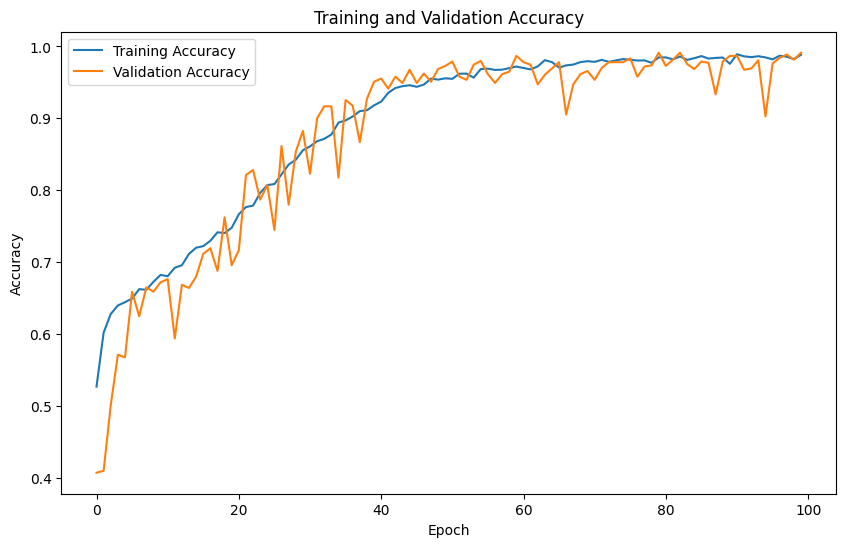

In [19]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
test_loss, test_accuracy = tm1.evaluate(X_test_augmented, y_test_augmented)

# Print the evaluation results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

33/33 [==============================] - 1s 13ms/step - loss: 0.2741 - accuracy: 0.9885
Test Loss: 0.2741180956363678
Test Accuracy: 0.9884615540504456


In [22]:
tm1.save('tm41a.h5')

In [29]:
# OPTIMIZER 2: Adam
tm1.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [30]:
history = tm1.fit(
    X_train_augmented, y_train_augmented,
    epochs=100,
    validation_data=(X_val_augmented, y_val_augmented),  # Use augmented validation data
    callbacks=[tensorboard_callback]
)

Epoch 1/100
172/172 [==============================] - 4s 19ms/step - loss: 1.8567 - accuracy: 0.7055 - val_loss: 1.3988 - val_accuracy: 0.7711
Epoch 2/100
172/172 [==============================] - 3s 18ms/step - loss: 1.3950 - accuracy: 0.7911 - val_loss: 1.4164 - val_accuracy: 0.7939
Epoch 3/100
172/172 [==============================] - 3s 18ms/step - loss: 1.4495 - accuracy: 0.8169 - val_loss: 2.2689 - val_accuracy: 0.5702
Epoch 4/100
172/172 [==============================] - 3s 18ms/step - loss: 1.4296 - accuracy: 0.8384 - val_loss: 1.4875 - val_accuracy: 0.8325
Epoch 5/100
172/172 [==============================] - 3s 18ms/step - loss: 1.4957 - accuracy: 0.8322 - val_loss: 2.1644 - val_accuracy: 0.6526
Epoch 6/100
172/172 [==============================] - 3s 18ms/step - loss: 1.5051 - accuracy: 0.8367 - val_loss: 1.3921 - val_accuracy: 0.8763
Epoch 7/100
172/172 [==============================] - 3s 19ms/step - loss: 1.4986 - accuracy: 0.8505 - val_loss: 1.6046 - val_accuracy:

In [ ]:
tm1.save('tm41b.h5')

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
# OPTIMIZER 3: RMSProp
tm1.compile(optimizer=tf.keras.optimizers.RMSprop(), loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [33]:
history = tm1.fit(
    X_train_augmented, y_train_augmented,
    epochs=100,
    validation_data=(X_val_augmented, y_val_augmented),  # Use augmented validation data
    callbacks=[tensorboard_callback]
)

Epoch 1/100
172/172 [==============================] - 4s 22ms/step - loss: 0.8331 - accuracy: 0.9147 - val_loss: 0.8259 - val_accuracy: 0.9228
Epoch 2/100
172/172 [==============================] - 4s 21ms/step - loss: 0.8277 - accuracy: 0.9153 - val_loss: 1.1060 - val_accuracy: 0.7237
Epoch 3/100
172/172 [==============================] - 4s 21ms/step - loss: 0.8209 - accuracy: 0.9196 - val_loss: 0.8439 - val_accuracy: 0.9088
Epoch 4/100
172/172 [==============================] - 4s 21ms/step - loss: 0.8452 - accuracy: 0.9082 - val_loss: 2.5109 - val_accuracy: 0.3175
Epoch 5/100
172/172 [==============================] - 4s 21ms/step - loss: 0.8598 - accuracy: 0.9127 - val_loss: 2.3031 - val_accuracy: 0.4193
Epoch 6/100
172/172 [==============================] - 4s 21ms/step - loss: 0.8079 - accuracy: 0.9218 - val_loss: 2.4687 - val_accuracy: 0.3833
Epoch 7/100
172/172 [==============================] - 4s 21ms/step - loss: 0.8569 - accuracy: 0.9140 - val_loss: 3.5101 - val_accuracy:

In [ ]:
tm1.save('tm41c.h5')

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### ------------------------------------------------- PRONet-5 -------------------------------------------------


In [23]:
# PRONet-5

tm2 = Sequential()
tm2.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape =(128,128,3), padding='same'))
tm2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

tm2.add(Conv2D(32, (3, 3), 1, activation='relu', padding='same'))
tm2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm2.add(Conv2D(64, (3, 3), 1, activation='relu', padding='same'))
tm2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm2.add(Dropout(0.5))

tm2.add(Flatten())
tm2.add(Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm2.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm2.add(Dense(4, activation="softmax"))
tm2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)      

In [24]:
tm2.compile(optimizer='sgd', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [25]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
history = tm2.fit(
    X_train_augmented, y_train_augmented,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)


Epoch 1/100
172/172 [==============================] - 3s 13ms/step - loss: 6.9344 - accuracy: 0.5069 - val_loss: 6.7061 - val_accuracy: 0.5021
Epoch 2/100
172/172 [==============================] - 2s 12ms/step - loss: 6.3602 - accuracy: 0.5833 - val_loss: 6.3080 - val_accuracy: 0.4938
Epoch 3/100
172/172 [==============================] - 2s 12ms/step - loss: 5.9601 - accuracy: 0.6051 - val_loss: 5.9946 - val_accuracy: 0.4979
Epoch 4/100
172/172 [==============================] - 2s 12ms/step - loss: 5.5957 - accuracy: 0.6093 - val_loss: 5.5725 - val_accuracy: 0.5344
Epoch 5/100
172/172 [==============================] - 2s 12ms/step - loss: 5.2530 - accuracy: 0.6149 - val_loss: 5.2370 - val_accuracy: 0.5437
Epoch 6/100
172/172 [==============================] - 2s 12ms/step - loss: 4.9488 - accuracy: 0.6258 - val_loss: 4.9555 - val_accuracy: 0.5490
Epoch 7/100
172/172 [==============================] - 2s 12ms/step - loss: 4.6587 - accuracy: 0.6338 - val_loss: 4.6725 - val_accuracy:

In [27]:
test_loss, test_accuracy = tm2.evaluate(X_test, y_test)

# Print the evaluation results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

30/30 [==============================] - 0s 11ms/step - loss: 0.2619 - accuracy: 0.9760
Test Loss: 0.26190945506095886
Test Accuracy: 0.9760416746139526


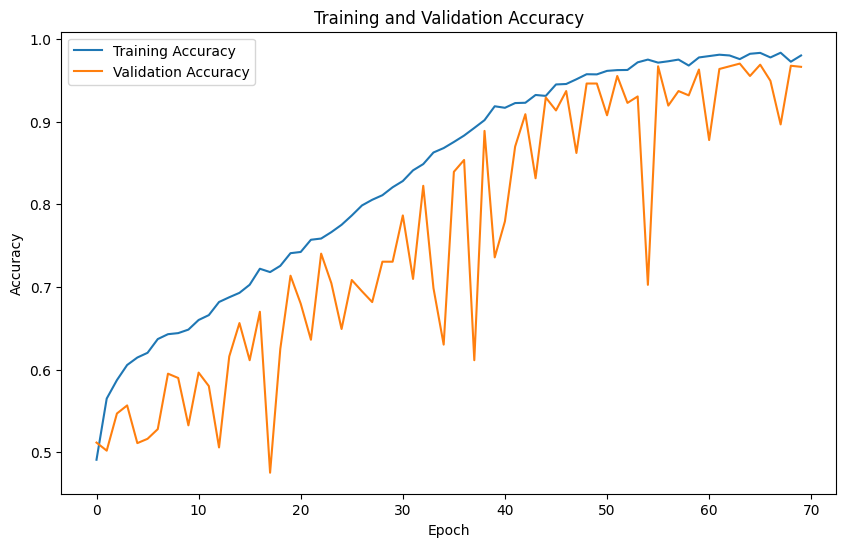

In [36]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
tm2.save('tm32.h5')

In [34]:
#OPTIMIZER 2: Adam
tm2.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [35]:
history = tm2.fit(
    X_train_augmented, y_train_augmented,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/100
172/172 [==============================] - 3s 14ms/step - loss: 1.0980 - accuracy: 0.7071 - val_loss: 0.8290 - val_accuracy: 0.7833
Epoch 2/100
172/172 [==============================] - 2s 12ms/step - loss: 0.7753 - accuracy: 0.8175 - val_loss: 0.8051 - val_accuracy: 0.8271
Epoch 3/100
172/172 [==============================] - 2s 13ms/step - loss: 0.7280 - accuracy: 0.8744 - val_loss: 0.8140 - val_accuracy: 0.8698
Epoch 4/100
172/172 [==============================] - 2s 13ms/step - loss: 0.7263 - accuracy: 0.8838 - val_loss: 0.7496 - val_accuracy: 0.8760
Epoch 5/100
172/172 [==============================] - 2s 13ms/step - loss: 0.7017 - accuracy: 0.8980 - val_loss: 0.6668 - val_accuracy: 0.9323
Epoch 6/100
172/172 [==============================] - 2s 13ms/step - loss: 0.6825 - accuracy: 0.9125 - val_loss: 0.7279 - val_accuracy: 0.8875
Epoch 7/100
172/172 [==============================] - 2s 13ms/step - loss: 0.6865 - accuracy: 0.9109 - val_loss: 0.6541 - val_accuracy:

In [36]:
test_loss, test_accuracy = tm2.evaluate(X_test, y_test)

# Print the evaluation results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

30/30 [==============================] - 0s 5ms/step - loss: 0.4354 - accuracy: 0.9604
Test Loss: 0.4354052245616913
Test Accuracy: 0.9604166746139526


In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
#OPTIMIZER 3: Adam
tm2.compile(optimizer=tf.keras.optimizers.RMSprop(), loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [38]:
history = tm2.fit(
    X_train_augmented, y_train_augmented,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/100
172/172 [==============================] - 3s 16ms/step - loss: 0.3254 - accuracy: 0.9489 - val_loss: 0.2499 - val_accuracy: 0.9698
Epoch 2/100
172/172 [==============================] - 3s 15ms/step - loss: 0.2686 - accuracy: 0.9551 - val_loss: 0.2875 - val_accuracy: 0.9438
Epoch 3/100
172/172 [==============================] - 2s 14ms/step - loss: 0.2667 - accuracy: 0.9516 - val_loss: 0.3331 - val_accuracy: 0.9354
Epoch 4/100
172/172 [==============================] - 2s 14ms/step - loss: 0.2556 - accuracy: 0.9544 - val_loss: 0.2642 - val_accuracy: 0.9542
Epoch 5/100
172/172 [==============================] - 2s 14ms/step - loss: 0.2757 - accuracy: 0.9484 - val_loss: 0.2347 - val_accuracy: 0.9719
Epoch 6/100
172/172 [==============================] - 2s 14ms/step - loss: 0.2685 - accuracy: 0.9515 - val_loss: 0.2552 - val_accuracy: 0.9615
Epoch 7/100
172/172 [==============================] - 2s 14ms/step - loss: 0.2772 - accuracy: 0.9518 - val_loss: 0.2347 - val_accuracy:

In [39]:
test_loss, test_accuracy = tm2.evaluate(X_test, y_test)

# Print the evaluation results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

30/30 [==============================] - 0s 5ms/step - loss: 0.1868 - accuracy: 0.9677
Test Loss: 0.1868266761302948
Test Accuracy: 0.9677083492279053


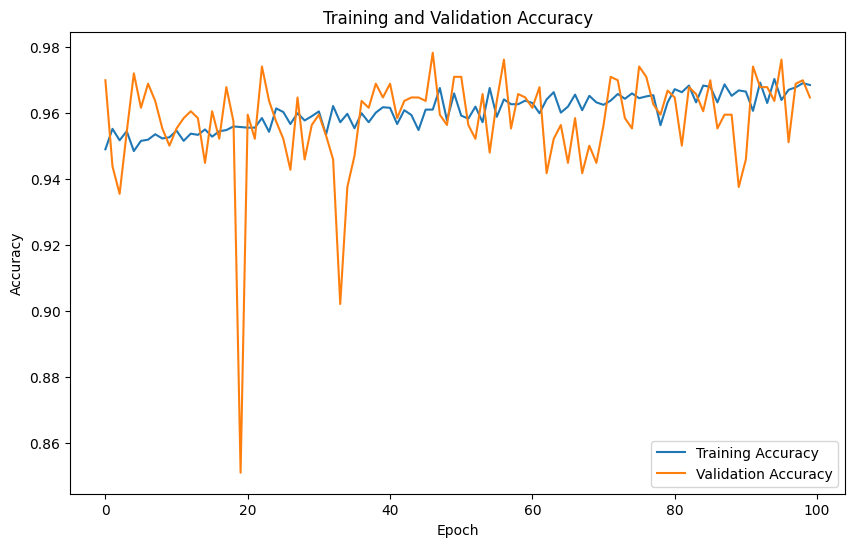

In [40]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()